## Digit Recognition using MNIST dataset
This example shows how to create, train and convert CNN model for digit recognition using Microcontroller

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/mnist/Digit_Recognition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/mnist/Digit_Recognition.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Code

## Load and prepare data for training

Setup Environments

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

print(tf.__version__)

import os
MODELS_DIR = 'models'
!rm -rf {TFLITE_DIR} {MODELS_DIR}

if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

!git clone -q --depth 1 https://github.com/dsettu/tflite

MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
MODEL_TFLITE_MICRO_C = os.path.join(MODELS_DIR, 'model.cpp')
MODEL_TFLITE_MICRO_H = os.path.join(MODELS_DIR, 'model.h')

MODEL_TFLITE_INT8_FULL = os.path.join(MODELS_DIR, 'model_int8_full.tflite')
MODEL_TFLITE_INT8_FULL_MICRO_C = os.path.join(MODELS_DIR, 'model_int8_full.cpp')
MODEL_TFLITE_INT8_FULL_MICRO_H = os.path.join(MODELS_DIR, 'model_int8_full.h')


2.7.0


Load and split MNIST dataset for training and validation

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, x_test.shape


11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

Display a sample image in inverted grayscale

5


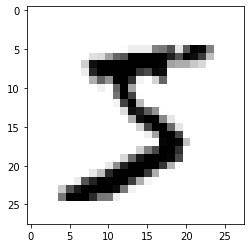

In [4]:
first_image = x_train[0]
first_label = y_train[0]
print(first_label)
plt.imshow(first_image, cmap='gray_r')

Reshape the input image to use with CNN model for training and validation

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Covert 8-bit pixel value to float and then normalize it 

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

## Create and Train CNN model



Create CNN model

In [7]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(2, (3, 3), input_shape=(28, 28, 1), activation = 'relu', name = 'conv2d0'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),name='maxpool'))
model.add(keras.layers.Conv2D(4, (3, 3), input_shape=(13, 13, 2), activation = 'relu', name = 'conv2d1'))
model.add(keras.layers.Conv2D(4, (3, 3), input_shape=(11, 11, 4), activation = 'relu', name = 'conv2d2'))
model.add(keras.layers.Conv2D(2, (3, 3), input_shape=(9, 9, 4), activation = 'relu', name = 'conv2d3'))
model.add(keras.layers.Flatten(name='flatten'))
model.add(keras.layers.Dense(10, activation='softmax',name='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d0 (Conv2D)            (None, 26, 26, 2)         20        
                                                                 
 maxpool (MaxPooling2D)      (None, 13, 13, 2)         0         
                                                                 
 conv2d1 (Conv2D)            (None, 11, 11, 4)         76        
                                                                 
 conv2d2 (Conv2D)            (None, 9, 9, 4)           148       
                                                                 
 conv2d3 (Conv2D)            (None, 7, 7, 2)           74        
                                                                 
 flatten (Flatten)           (None, 98)                0         
                                                                 
 softmax (Dense)             (None, 10)                9

Train the model

In [8]:
epochs = 5
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train,y=y_train, epochs=epochs, batch_size=100, validation_data = (x_test, y_test), verbose=1)

Epoch 1/5
600/600 [==============================] - 34s 7ms/step - loss: 0.7911 - accuracy: 0.7397 - val_loss: 0.3531 - val_accuracy: 0.8849
Epoch 2/5
600/600 [==============================] - 4s 6ms/step - loss: 0.3138 - accuracy: 0.9023 - val_loss: 0.2417 - val_accuracy: 0.9243
Epoch 3/5
600/600 [==============================] - 4s 6ms/step - loss: 0.2421 - accuracy: 0.9246 - val_loss: 0.1992 - val_accuracy: 0.9402
Epoch 4/5
600/600 [==============================] - 4s 6ms/step - loss: 0.2056 - accuracy: 0.9362 - val_loss: 0.1761 - val_accuracy: 0.9460
Epoch 5/5
600/600 [==============================] - 4s 6ms/step - loss: 0.1836 - accuracy: 0.9435 - val_loss: 0.1594 - val_accuracy: 0.9515


Plot Learning Curve

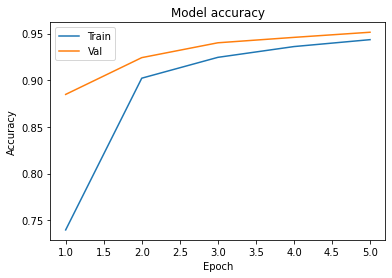

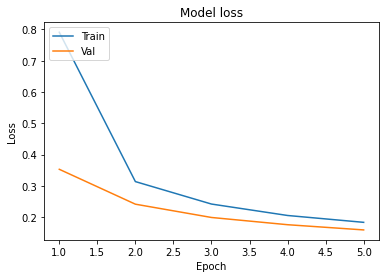

In [9]:
def plot_learningCurve(history, epochs):
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(history, epochs)

Plot confusion matrix

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efbb0523850>)

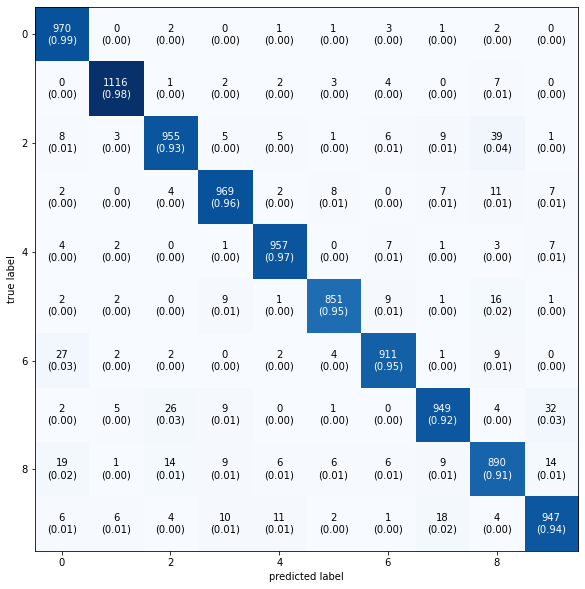

In [10]:
y_pred = np.argmax(model.predict(x_test), axis=-1) 
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(10,10))

Now we will need to convert and save our model into a downloadable file that will be appropriate for a microcontroller. This is done using the TensorFlow Lite Converter. The `TFLITE_BUILTINS` option tells the converter to only use TensorFlow Lite built in operations.

# Convert the model to Tensorflow Lite Format


Convert to a TensorFlow Lite model - without quantization

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(MODEL_TFLITE, "wb").write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpu9u1m6dt/assets


8556

Generate C File

In [16]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model,  "g_model")

with  open(MODEL_TFLITE_MICRO_H,  'w')  as  file:
    file.write(header_text)

with  open(MODEL_TFLITE_MICRO_C,  'w')  as  file:
    file.write(source_text)

Convert to a TensorFlow Lite model - using integer-only 

In [13]:
def representative_dataset_gen():
  for i in range(len(x_train)):
      input = x_train[i].reshape(1,28,28,1)
      input = input.astype(np.float32)
      yield [input]

converter=tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, 
# we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
# Provide a representative dataset to ensure we quantize correctly.
tflite_model_int8_full = converter.convert()

open(MODEL_TFLITE_INT8_FULL, "wb").write(tflite_model_int8_full)

INFO:tensorflow:Assets written to: /tmp/tmpbmrchmln/assets


INFO:tensorflow:Assets written to: /tmp/tmpbmrchmln/assets


5536

Plot Confusion matrix for converted model

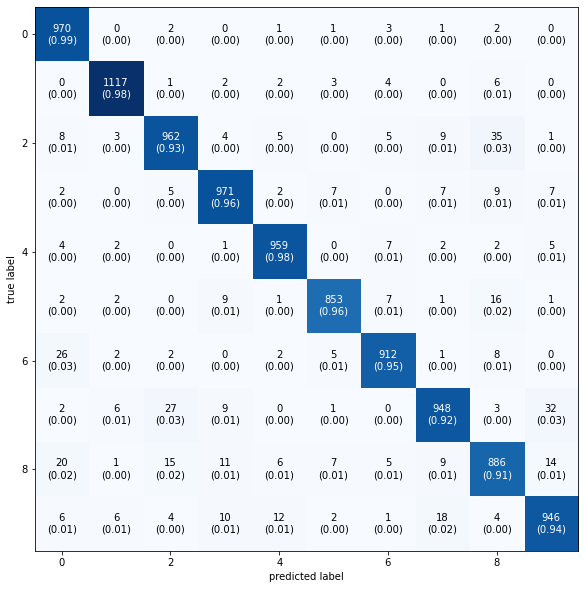

In [14]:
# Initialize an interpreter with the model
interpreter = tf.lite.Interpreter(MODEL_TFLITE_INT8_FULL)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Create arrays to store the results
model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(x_test)):
  tf_input = x_test[i].reshape(1,28,28,1)
  tf_input = tf_input.astype(np.float32)

# Manually quantize the input from float to integer
  scale, zero_point = input_details['quantization']
  tflite_integer_input = tf_input / scale + zero_point
  tflite_integer_input = tflite_integer_input.astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], tflite_integer_input)

  interpreter.invoke()

  output_details = interpreter.get_output_details()[0]
  tflite_integer_output = interpreter.get_tensor(output_details['index'])
  # Manually dequantize the output from integer to float
  scale, zero_point = output_details['quantization']
  tflite_output = tflite_integer_output.astype(np.float32)
  tflite_output = (tflite_output - zero_point) * scale

  model_predictions.append(tflite_output[0])

# Plot Confusion matrix
y_pred=np.argmax(model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(10,10))
plt.show()

Generate C File

In [15]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model_int8_full,  "g_model")

with  open(MODEL_TFLITE_INT8_FULL_MICRO_H,  'w')  as  file:
    file.write(header_text)

with  open(MODEL_TFLITE_INT8_FULL_MICRO_C,  'w')  as  file:
    file.write(source_text)